We will come back to this!
1. Define Activity Durations
For each activity type, define a typical duration or a range of possible durations. This could be based on:

Historical data from your NHTS dataset.
Statistical averages for each activity type.
2. Calculate Total Time for Base Sequence
For each individual, after generating the base sequence (e.g., H-PD-W-PD-H), calculate the total time spent on these activities.

3. Integrate Activities Using Likelihoods and Time Constraints
When you want to add an activity to a sequence based on likelihood:

Check its duration.
Verify if the addition of this activity will breach the 24-hour limit when combined with the total time already allocated for the current sequence.
If adding the activity will breach the limit, either:
Skip to the next activity in the likelihood ranking.
Adjust the duration (if there's a variable range) to fit within the limit.
4. Consider Transition Times
In real life, moving from one activity to another also consumes time. For example, transitioning from work (W) to shopping (S) might require 30 minutes of commute. This "transition time" should also be taken into account when adding activities.

5. Iteratively Refine Sequences
As you add each activity, recalculate the remaining available time in the day.
Be sure to consider both the activity duration and any transition time.
Adjust and refine the sequence iteratively until the total time is filled adequately or you run out of meaningful activities to add.
6. Validation
After generating activity sequences for all individuals, validate the sequences against real-world data (if available) or sanity checks.
Ensure no individual's activities exceed 24 hours and that sequences look plausible based on known patterns of human behavior.
By integrating the time constraint into your approach, you can generate activity sequences that are not only probable but also feasible within a day's timeframe. This method will make your synthetic population's behavior more realistic and reflective of actual human activity patterns.


In [1]:
!jupyter nbextension enable --py widgetsnbextension

'DOSKEY' is not recognized as an internal or external command,
operable program or batch file.
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


# Activity explorer
This piece of code is to explore the function of going through the synthetic population and grabbing an appropriate activity profile for the individual

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import interp1d
from sklearn.mixture import GaussianMixture
import scipy.stats as stats
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.utils import class_weight

import tripsender.nhts as nhts


## Load and clean data

In [30]:
# Read data
nhts_data = pd.read_csv('data/raw/NHTS/Data_RVU_2017_GBG_utanEXTRA.csv', sep=';')

# Preprocess data
df_activity = nhts.preprocess_data(nhts_data,unique_trips_only = False)
df_persons = nhts.preprocess_data(nhts_data,unique_trips_only = True)

c:\Users\ssanjay\AppData\Local\Continuum\anaconda3\envs\tripsender\lib\site-packages\IPython\core\interactiveshell.py:3266: DtypeWarning: Columns (34,41,42,43) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


# Determining secondary activity

In [31]:
# Create a dictionary to help rename activities to abbrevations
activity_to_abbrevation = {
    'Work': 'W',
    'Home': 'H',
    'Leisure': 'L',
    'Grocery shopping': 'SG',
    'Other shopping': 'SO',
    'Education': 'E',
    'Pickup/Dropoff child': 'PD',
    'Travel': 'T',
    'Healthcare': 'HC',
    'Other': 'X'
}

# Set 'id' as index for df_persons for efficient mapping
df_persons.set_index('id', inplace=True)

# Create an activity sequence for each person
df_activity['abbreviated_purpose'] = df_activity['purpose'].map(activity_to_abbrevation)
activity_sequence = df_activity.groupby('id')['abbreviated_purpose'].apply(lambda x: '-'.join(x))

# Prefix with 'H' if not starting with 'H'
df_persons['activity_sequence'] = activity_sequence.apply(lambda x: 'H-' + x if x[0] != 'H' else x)

def clean_sequence(sequence):
    activities = sequence.split('-')
    cleaned_activities = [activities[0]]

    for i in range(1, len(activities)):
        if activities[i] != activities[i-1]:
            cleaned_activities.append(activities[i])

    return '-'.join(cleaned_activities)

# Apply the function to the activity_sequence column
df_persons['activity_sequence'] = df_persons['activity_sequence'].apply(clean_sequence)

# Determine primary status based on activity sequence
def determine_primary_status(sequence):
    if 'W' in sequence:
        return 1  # Work
    elif 'E' in sequence:
        return 2  # Education
    else:
        return 3  # Neither
def determine_secondary_status(sequence, primary_status):
    # Convert the sequence string back to a list
    activities = sequence.split('-')
    
    # Filter out 'Home', 'PD', and the primary status
    if primary_status == 1:  # Work
        filtered_activities = [act for act in activities if act not in ['H', 'W', 'PD']]
    elif primary_status == 2:  # Education
        filtered_activities = [act for act in activities if act not in ['H', 'E', 'PD']]
    else:  # Neither
        filtered_activities = [act for act in activities if act not in ['H', 'PD']]
    
    # If the filtered activities list is empty, return np.nan
    if not filtered_activities:
        return np.nan

    # Otherwise, return the filtered activities as a list of strings
    return filtered_activities

# Create the secondary_status column
#df_persons['secondary_status'] = df_persons.apply(lambda row: determine_secondary_status(row['activity_sequence'], row['primary_status']), axis=1)



df_persons['primary_status'] = df_persons['activity_sequence'].apply(determine_primary_status)

# Reset the index of df_persons
df_persons.reset_index(inplace=True)

# Print counts of each primary status with labels
value_counts = df_persons['primary_status'].value_counts()
print(f'Work: {value_counts.get(1, 0)}')
print(f'Education: {value_counts.get(2, 0)}')
print(f'Neither: {value_counts.get(3, 0)}')

Work: 10318
Education: 828
Neither: 5491


In [25]:
unique_lists = set(df_persons['secondary_status'].dropna().apply(tuple))

# Convert sets of tuples back to lists for easier viewing
unique_lists = [list(t) for t in unique_lists]

print(unique_lists)
print(len(unique_lists))

[['SO', 'HC'], ['L', 'X', 'L', 'SG'], ['L', 'SG', 'X', 'L', 'X'], ['HC'], ['SG', 'SO', 'X', 'L'], ['L', 'X', 'HC', 'SG'], ['SG', 'L', 'X'], ['L', 'X', 'X', 'SG'], ['T', 'SO', 'L'], ['L', 'L', 'SG', 'L'], ['HC', 'L', 'X'], ['X', 'HC', 'X'], ['L', 'SG', 'SO', 'L'], ['X', 'X', 'X'], ['X', 'L', 'SO', 'L', 'X', 'L'], ['SG', 'HC', 'X'], ['L', 'HC', 'X'], ['SO', 'SG', 'SO'], ['L', 'X', 'X'], ['L', 'SG', 'SG'], ['T', 'T', 'T', 'SO', 'SG'], ['L', 'X', 'T'], ['X', 'L', 'X', 'SG', 'L'], ['X', 'X', 'X', 'L'], ['SG', 'L', 'L'], ['SO', 'SG', 'HC', 'X'], ['L', 'T', 'L', 'SG'], ['T', 'SO', 'T', 'X', 'SG', 'L'], ['X', 'L', 'SO'], ['X', 'SO', 'X'], ['T', 'E'], ['X', 'T'], ['L', 'L', 'SO', 'L'], ['HC', 'SO'], ['SG', 'L'], ['X', 'SO'], ['L', 'T'], ['L', 'X'], ['T', 'T', 'SG'], ['SG', 'X', 'L'], ['L', 'SO', 'X'], ['SO', 'X', 'L', 'SO'], ['X', 'L', 'HC', 'SO', 'L', 'X', 'X'], ['SG', 'HC', 'L'], ['SO', 'L', 'X'], ['SG', 'SO', 'SG'], ['T', 'L', 'L', 'SG'], ['X', 'L', 'X', 'SO'], ['HC', 'SO', 'SG'], ['X', 'SO'

# Setting up for model training

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import interp1d
from sklearn.mixture import GaussianMixture
import scipy.stats as stats
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
# import best_grid

# drop, id, start_time, purpose, mode, end_time distance_km and activity_sequence
df_persons_model = df_persons.drop(['id','start_time','purpose','mode','end_time','distance_km','activity_sequence','weight_individual'],axis=1)

# Convert categorical variables to one-hot encoded variables
ohe = OneHotEncoder(sparse=False)
categorical_variables = ['sex', 'age_group', 'house_type', 'household_type']


# One-hot encode categorical variables
df_persons_model_ohe = pd.DataFrame(ohe.fit_transform(df_persons_model[categorical_variables]))
df_persons_model_ohe.columns = ohe.get_feature_names()

# Merge with original dataframe and drop original categorical columns
df_persons_model = df_persons_model.drop(categorical_variables, axis=1).reset_index(drop=True)
df_persons_model = pd.concat([df_persons_model, df_persons_model_ohe], axis=1)
# Split dataset into training and test sets
X = df_persons_model.drop(['primary_status'], axis=1)
X['x2_Not Available'] = 0
y = df_persons_model['primary_status']

# Print distribution
print(f"Distribution {y.value_counts(normalize=True)}")

# Split data and weights
# First, split the data into a training set and a temporary set using 80-20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


Distribution 1    0.620184
3    0.330047
2    0.049769
Name: primary_status, dtype: float64


## Baseline model

In [6]:
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)

# Predict on the validation set
y_pred = rfc.predict(X_test)

# Evaluate the model on the validation data
print(f"Validation overall accuracy score: {accuracy_score(y_test, y_pred):.2f}")

# Print categorical accuracy for validation data
print(f"Validation working accuracy score: {accuracy_score(y_test[y_test == 1], y_pred[y_test == 1]):.2f}")
print(f"Validation studying accuracy score: {accuracy_score(y_test[y_test == 2], y_pred[y_test == 2]):.2f}")
print(f"Validation neither accuracy score: {accuracy_score(y_test[y_test == 3], y_pred[y_test == 3]):.2f}")

# Value count the predicted classes
predicted_counts = pd.Series(y_pred).value_counts()
print(predicted_counts)

Validation overall accuracy score: 0.81
Validation working accuracy score: 0.92
Validation studying accuracy score: 0.50
Validation neither accuracy score: 0.65
1    2341
3     858
2     129
dtype: int64


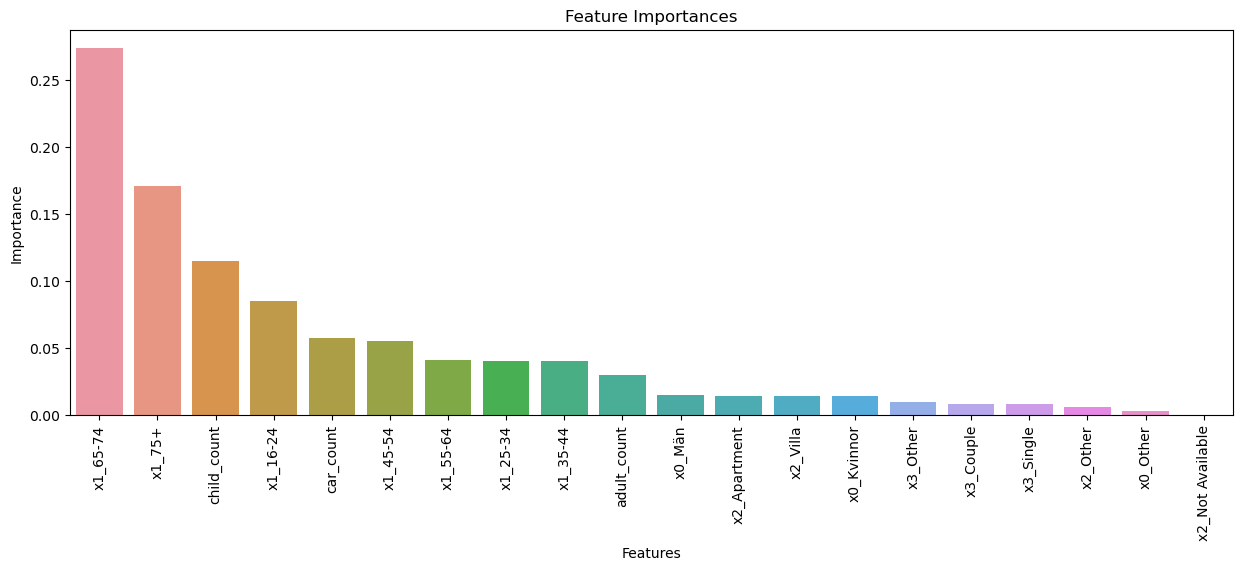

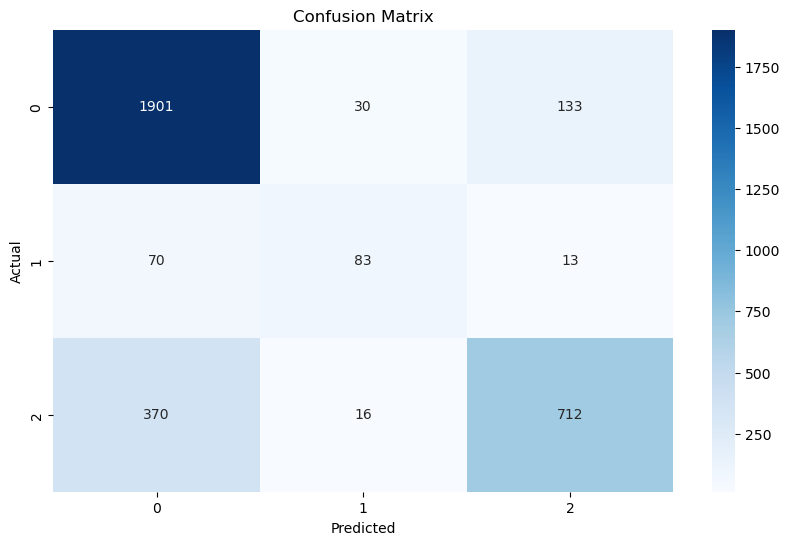

In [7]:
cm = confusion_matrix(y_test, y_pred)
ac = accuracy_score(y_test, y_pred)

# Visualize feature importances and confusion matrix
plt.figure(figsize=(15, 5))
sns.barplot(x='feature', y='feature_importance', data=pd.DataFrame({'feature': X.columns, 'feature_importance': rfc.feature_importances_}).sort_values('feature_importance', ascending=False))
plt.title('Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Hyperparameter tuning

Best parameters: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Accuracy score: 0.81  
Working accuracy score: 0.95  
Studying accuracy score: 0.54  
Neither accuracy score: 0.61  
Macro-Averaged F1-Score: 0.73  
  
Best parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}  
Accuracy score: 0.81  
Working accuracy score: 0.92  
Studying accuracy score: 0.50  
Neither accuracy score: 0.66  
Macro-Averaged F1-Score: 0.73  

In [8]:
# Train a RandomForestClassifier
params = {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
rfc_tuned = RandomForestClassifier(random_state = 42,**params)
rfc_tuned.fit(X_train, y_train)
# Predict on the test set
y_pred = rfc_tuned.predict(X_test)
# Evaluate the model
print(f"Accuracy score: {accuracy_score(y_test, y_pred):.2f}")
# Print categorical accuracy
print(f"working accuracy score: {accuracy_score(y_test[y_test == 1], y_pred[y_test == 1]):.2f}")
print(f"studying accuracy score: {accuracy_score(y_test[y_test == 2], y_pred[y_test == 2]):.2f}")
print(f"neither accuracy score: {accuracy_score(y_test[y_test == 3], y_pred[y_test == 3]):.2f}")

cm_hyperparameter = confusion_matrix(y_test, y_pred)
ac_hyperparameter = accuracy_score(y_test, y_pred)


Accuracy score: 0.81
working accuracy score: 0.93
studying accuracy score: 0.48
neither accuracy score: 0.62


# SMOTE

In [9]:
from sklearn.utils import class_weight

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Calculate sample weights for the original training set
class_weights = class_weight.compute_class_weight('balanced', classes=[1,2,3], y=y_train)
weights_train = y_train.map(dict(zip([1,2,3,4], class_weights)))

# Assign these weights to synthetic samples
weights_resampled = pd.concat([weights_train, pd.Series([1] * (len(y_train_resampled) - len(y_train)))], axis=0)

# Train a RandomForestClassifier with weights
rfc_smote = RandomForestClassifier(random_state=42)
rfc_smote.fit(X_train_resampled, y_train_resampled, sample_weight=weights_resampled)

# Predict on the test set
y_pred = rfc_smote.predict(X_test)

# Evaluate the model
print(f"Accuracy score: {accuracy_score(y_test, y_pred):.2f}")

# Print categorical accuracy
print(f"working accuracy score: {accuracy_score(y_test[y_test == 1], y_pred[y_test == 1]):.2f}")
print(f"studying accuracy score: {accuracy_score(y_test[y_test == 2], y_pred[y_test == 2]):.2f}")
print(f"neither accuracy score: {accuracy_score(y_test[y_test == 3], y_pred[y_test == 3]):.2f}")

cm_smote = confusion_matrix(y_test, y_pred)
ac_smote = accuracy_score(y_test, y_pred)


Accuracy score: 0.69
working accuracy score: 0.64
studying accuracy score: 0.80
neither accuracy score: 0.77


## SMOTE + hyperparameter

In [10]:
# Train a RandomForestClassifier with hyperparameters and weights
rfc_smote_tuned = RandomForestClassifier(**params)
rfc_smote_tuned.fit(X_train_resampled, y_train_resampled, sample_weight=weights_resampled)

# Predict on the test set
y_pred = rfc_smote_tuned.predict(X_test)

# Evaluate the model
print(f"Accuracy score: {accuracy_score(y_test, y_pred):.2f}")

# Print categorical accuracy
print(f"working accuracy score: {accuracy_score(y_test[y_test == 1], y_pred[y_test == 1]):.2f}")
print(f"studying accuracy score: {accuracy_score(y_test[y_test == 2], y_pred[y_test == 2]):.2f}")
print(f"neither accuracy score: {accuracy_score(y_test[y_test == 3], y_pred[y_test == 3]):.2f}")

cm_smote_hyperparameter = confusion_matrix(y_test, y_pred)
ac_smote_hyperparameter = accuracy_score(y_test, y_pred)


Accuracy score: 0.70
working accuracy score: 0.66
studying accuracy score: 0.83
neither accuracy score: 0.75


## Weighting classes

In [11]:
# Calculate the unique class labels
unique_labels = np.unique(y_train)
# Compute class weights
class_weights = class_weight.compute_class_weight('balanced', unique_labels, y_train)
# Convert class weights to a dictionary
class_weight_dict = {label: weight for label, weight in zip(unique_labels, class_weights)}

rfc_weighted = RandomForestClassifier(class_weight=class_weight_dict, random_state=42)
rfc_weighted.fit(X_train, y_train)
# Predictions and evaluation remain the same as before
y_pred = rfc_weighted.predict(X_test)
print(f"Accuracy score: {accuracy_score(y_test, y_pred):.2f}")
# Print categorical accuracy
print(f"working accuracy score: {accuracy_score(y_test[y_test == 1], y_pred[y_test == 1]):.2f}")
print(f"studying accuracy score: {accuracy_score(y_test[y_test == 2], y_pred[y_test == 2]):.2f}")
print(f"neither accuracy score: {accuracy_score(y_test[y_test == 3], y_pred[y_test == 3]):.2f}")

cm_weight = confusion_matrix(y_test, y_pred)
ac_weight = accuracy_score(y_test, y_pred)

C:\Users\ssanjay\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[1 2 3], y=12533    1
13885    3
2770     3
12265    1
371      1
        ..
14142    1
8136     1
13374    1
8294     1
10555    1
Name: primary_status, Length: 13309, dtype: int64 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Accuracy score: 0.76
working accuracy score: 0.78
studying accuracy score: 0.78
neither accuracy score: 0.71


## Weighting classes + hyperparameter tuning

In [12]:
# Calculate the unique class labels
unique_labels = np.unique(y_train)

# Compute class weights
class_weights = class_weight.compute_class_weight('balanced', unique_labels, y_train)
# Convert class weights to a dictionary
class_weight_dict = {label: weight for label, weight in zip(unique_labels, class_weights)}

# Initialize and train the RandomForest with class weights
rfc_weighted_tuned = RandomForestClassifier(class_weight=class_weight_dict,**params)
rfc_weighted_tuned.fit(X_train, y_train)
# Predictions and evaluation remain the same as before
y_pred = rfc_weighted_tuned.predict(X_test)
print(f"Accuracy score: {accuracy_score(y_test, y_pred):.2f}")
# Print categorical accuracy
print(f"working accuracy score: {accuracy_score(y_test[y_test == 1], y_pred[y_test == 1]):.2f}")
print(f"studying accuracy score: {accuracy_score(y_test[y_test == 2], y_pred[y_test == 2]):.2f}")
print(f"neither accuracy score: {accuracy_score(y_test[y_test == 3], y_pred[y_test == 3]):.2f}")


cm_weight_hyperparameter = confusion_matrix(y_test, y_pred)
ac_weight_hyperparameter = accuracy_score(y_test, y_pred)


C:\Users\ssanjay\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[1 2 3], y=12533    1
13885    3
2770     3
12265    1
371      1
        ..
14142    1
8136     1
13374    1
8294     1
10555    1
Name: primary_status, Length: 13309, dtype: int64 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Accuracy score: 0.77
working accuracy score: 0.82
studying accuracy score: 0.79
neither accuracy score: 0.68


# SMOTE + Hyperparameter + Weights

In [13]:
# Initialize and train the RandomForest with class weights
rfc_smote_tuned_weighted = RandomForestClassifier(class_weight=class_weight_dict, **params)
rfc_smote_tuned_weighted.fit(X_train_resampled, y_train_resampled)

# Predictions and evaluation
y_pred = rfc_smote_tuned_weighted.predict(X_test)
print(f"Accuracy score: {accuracy_score(y_test, y_pred):.2f}")
# Print categorical accuracy
print(f"working accuracy score: {accuracy_score(y_test[y_test == 1], y_pred[y_test == 1]):.2f}")
print(f"studying accuracy score: {accuracy_score(y_test[y_test == 2], y_pred[y_test == 2]):.2f}")
print(f"neither accuracy score: {accuracy_score(y_test[y_test == 3], y_pred[y_test == 3]):.2f}")
cm_smote_wight_hp = confusion_matrix(y_test, y_pred)
ac_smote_wight_hp = accuracy_score(y_test, y_pred)


Accuracy score: 0.58
working accuracy score: 0.56
studying accuracy score: 0.91
neither accuracy score: 0.57


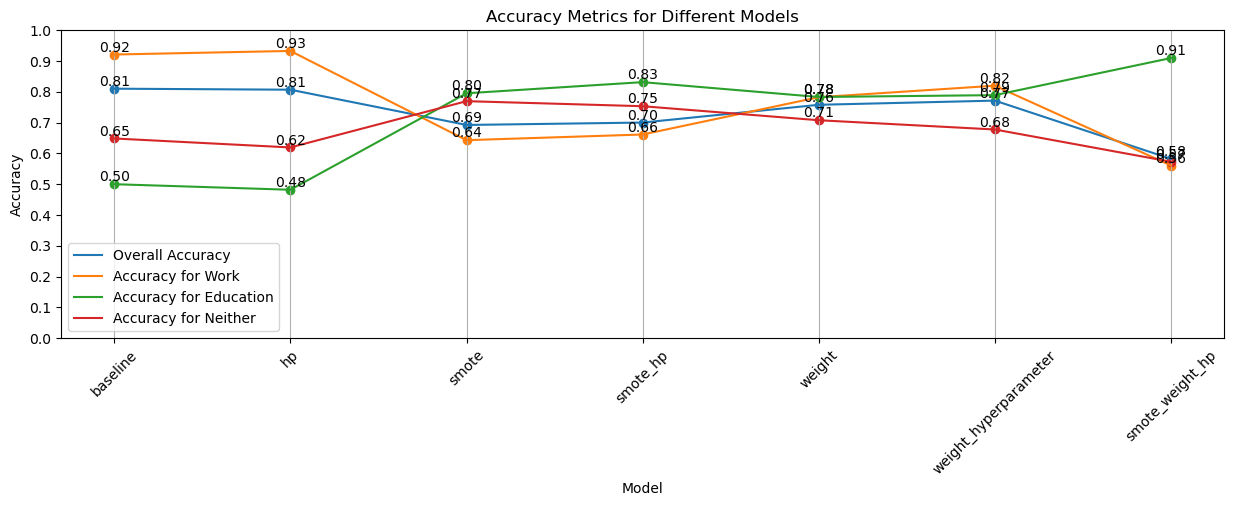

In [14]:
list_of_cm_array = [cm, cm_hyperparameter, cm_smote, cm_smote_hyperparameter, cm_weight, cm_weight_hyperparameter, cm_smote_wight_hp]
list_of_model_names = ['baseline', 'hp', 'smote', 'smote_hp', 'weight', 'weight_hyperparameter', 'smote_weight_hp']
list_of_accuracies = [ac, ac_hyperparameter, ac_smote, ac_smote_hyperparameter, ac_weight, ac_weight_hyperparameter, ac_smote_wight_hp]



# Define a function to calculate class accuracy
def class_accuracy(cm):
    # Diagonal elements are true positives for each class
    true_positives = [cm[i][i] for i in range(3)]
    
    # Sum of each row gives the total number of instances for each class
    total_instances = [sum(row) for row in cm]
    
    return [tp/tot if tot != 0 else 0 for tp, tot in zip(true_positives, total_instances)]

# Calculate class-specific accuracies for each confusion matrix
class_accuracies = [class_accuracy(cm) for cm in list_of_cm_array]

# Separate out accuracies for each class
class_1_accuracies = [acc[0] for acc in class_accuracies]
class_2_accuracies = [acc[1] for acc in class_accuracies]
class_3_accuracies = [acc[2] for acc in class_accuracies]


# Create a DataFrame
df_cm = pd.DataFrame({
    'model': list_of_model_names,
    'overall_accuracy': list_of_accuracies,
    'Accuracy for Work': class_1_accuracies,
    'Accuracy for Education': class_2_accuracies,
    'Accuracy for Neither': class_3_accuracies
})

df_cm.set_index('model', inplace=True)

# Plot the accuracies as line plots
plt.figure(figsize=(15, 4))
plt.plot(df_cm.index, df_cm['overall_accuracy'], label='Overall Accuracy')
plt.plot(df_cm.index, df_cm['Accuracy for Work'], label='Accuracy for Work')
plt.plot(df_cm.index, df_cm['Accuracy for Education'], label='Accuracy for Education')
plt.plot(df_cm.index, df_cm['Accuracy for Neither'], label='Accuracy for Neither')
plt.legend()
plt.title('Accuracy Metrics for Different Models')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)

# Draw lines at each x tick
plt.grid(axis='x')
# Add a marker with a label at data point
plt.scatter(df_cm.index, df_cm['overall_accuracy'], marker='o', label='Overall Accuracy')
plt.scatter(df_cm.index, df_cm['Accuracy for Work'], marker='o', label='Accuracy for Work')
plt.scatter(df_cm.index, df_cm['Accuracy for Education'], marker='o', label='Accuracy for Education')
plt.scatter(df_cm.index, df_cm['Accuracy for Neither'], marker='o', label='Accuracy for Neither')

# Add a data label for each point
for x, y in zip(df_cm.index, df_cm['overall_accuracy']):
    plt.text(x, y, f'{y:.2f}', ha='center', va='bottom')
for x, y in zip(df_cm.index, df_cm['Accuracy for Work']):
    plt.text(x, y, f'{y:.2f}', ha='center', va='bottom')
for x, y in zip(df_cm.index, df_cm['Accuracy for Education']):
    plt.text(x, y, f'{y:.2f}', ha='center', va='bottom')
for x, y in zip(df_cm.index, df_cm['Accuracy for Neither']):
    plt.text(x, y, f'{y:.2f}', ha='center', va='bottom')
    
# Make y ticks from 0 to 1 with 0.1 spacing
plt.yticks(np.arange(0, 1.1, 0.1))
plt.show()

In [15]:
df_cm

,overall_accuracy,Accuracy for Work,Accuracy for Education,Accuracy for Neither
model,,,,
baseline,0.810096,0.921027,0.500000,0.648452
hp,0.806791,0.932655,0.481928,0.619308
smote,0.692308,0.642926,0.795181,0.769581
smote_hp,0.700120,0.661337,0.831325,0.753188
weight,0.757812,0.782461,0.783133,0.707650
weight_hyperparameter,0.771334,0.819767,0.789157,0.677596
smote_weight_hp,0.582031,0.560562,0.909639,0.572860


In [16]:
# Print highest accuracy for each class and which model achieved it
print(f"Class 1: {df_cm['Accuracy for Work'].max():.2f} achieved by {df_cm['Accuracy for Work'].idxmax()}")
print(f"Class 2: {df_cm['Accuracy for Education'].max():.2f} achieved by {df_cm['Accuracy for Education'].idxmax()}")
print(f"Class 3: {df_cm['Accuracy for Neither'].max():.2f} achieved by {df_cm['Accuracy for Neither'].idxmax()}")



Class 1: 0.93 achieved by hp
Class 2: 0.91 achieved by smote_weight_hp
Class 3: 0.77 achieved by smote


# Saving the best model (weight_hyperparameter) to file

In [17]:
# Saving weight_hyperparameter model using joblib
import joblib
joblib.dump(rfc_weighted_tuned, 'models/NHTS_PRIMARY_STATUS_CLASSIFIER.joblib')


['models/NHTS_PRIMARY_STATUS_CLASSIFIER.joblib']

In [18]:
print(f'Workers: {value_counts.get(1, 0)}')
print(f'Students: {value_counts.get(2, 0)}')
print(f'Inactive: {value_counts.get(3, 0)}')
# Unpickle households
from tripsender.household import Household
import pickle
Household.clear_instances()
pickle_path = "data/synthesised_population/20230914_households_2022_107 Haga.pkl"
Household.instances = pickle.load(open(pickle_path, "rb"))
df_synth,persons = Household.return_nhts(drop=['primary_status'], onehotencode=True)
df_synth['x0_Other'] = 0
aligned_columns = [
    'child_count', 'adult_count', 'car_count', 'x0_Kvinnor', 'x0_Män', 'x0_Other',
    'x1_16-24', 'x1_25-34', 'x1_35-44', 'x1_45-54', 'x1_55-64', 'x1_65-74',
    'x1_75+', 'x2_Apartment', 'x2_Other', 'x2_Villa', 'x3_Couple',
    'x3_Other', 'x3_Single', 'x2_Not Available'
]
df_synth = df_synth[aligned_columns]

# Predict the number of cars for each person using the classifier
pred = rfc.predict(df_synth)

# Add the primary status each person
for i, person in enumerate(persons):
    person.primary_status = pred[i]

working = [person for person in persons if person.primary_status == 1]
studying = [person for person in persons if person.primary_status == 2]
inactive = [person for person in persons if person.primary_status == 3]


print(f"Number of workers: {len(working)} - {len(working)/len(persons)*100:.2f}%")
print(f"Number of students: {len(studying)} - {len(studying)/len(persons)*100:.2f}%")
print(f"Number of inactive: {len(inactive)} - {len(inactive)/len(persons)*100:.2f}%")


Workers: 10318
Students: 828
Inactive: 5491


Number of workers: 1832 - 57.52%
Number of students: 118 - 3.70%
Number of inactive: 1235 - 38.78%
